In [1]:
from neuron import h
h.nrn_load_dll("/Users/lillikiessling/Documents/Stanford/Code/BC_model/Ion_channels/arm64/libnrnmech.dylib")
h.load_file('stdrun.hoc') 
import numpy as np
import matplotlib.pyplot as plt

--No graphics will be displayed.


In [2]:
LJP = 0 # liquid junction potential in mV (bit cheesy to add this)

def I_t_curve(soma, ion, Vtest, Vhold, thold, tstep, ttail=2.0, ljp=0.0):
    clamp = h.VClamp(soma(0.5))
    # set integration time step
    h.dt = 0.001
    h.celsius = 20
    clamp.dur[0] = thold
    clamp.amp[0] = Vhold + ljp
    clamp.dur[1] = tstep
    clamp.amp[1] = Vtest + ljp
    clamp.dur[2] = ttail
    clamp.amp[2] = Vhold + ljp

    t = h.Vector().record(h._ref_t)
    if ion == 'na':
        i = h.Vector().record(soma(0.5)._ref_ina)
    elif ion == 'k':
        i = h.Vector().record(soma(0.5)._ref_ik)
    elif ion == 'h':
        i = h.Vector().record(soma(0.5)._ref_ih)
    elif ion == 'ca':
        i = h.Vector().record(soma(0.5)._ref_ica)
    h.finitialize(Vhold)
    h.continuerun(thold + tstep + ttail)
    t = np.array(t)
    i = np.array(i)
    del clamp
    return t, i

def I_V_curve(soma, ion, Vtests, Vhold, thold, tstep, ttail=2.0, method=min, ljp=0.0):
    h.dt = 0.001
    h.celsius = 20
    I_peaks = []
    for Vtest in Vtests:
        clamp = h.VClamp(soma(0.5))
        clamp.dur[0] = thold
        clamp.amp[0] = Vhold + ljp
        clamp.dur[1] = tstep
        clamp.amp[1] = Vtest + ljp
        clamp.dur[2] = ttail
        clamp.amp[2] = Vhold + ljp
        t = h.Vector().record(h._ref_t)
        if ion == 'na':
            i = h.Vector().record(soma(0.5)._ref_ina)
        elif ion == 'k':
            i = h.Vector().record(soma(0.5)._ref_ik)
        elif ion == 'h':
            i = h.Vector().record(soma(0.5)._ref_ih)
        elif ion == 'ca':
            i = h.Vector().record(soma(0.5)._ref_ica)
        # print(f"Running Vtest = {Vtest:+.1f} mV, "
        #     f"Vhold = {Vhold:+.1f} mV, "
        #     f"T = {h.celsius:.1f} °C, "
        #     f"ena = {soma(0.5).ena:.3f} mV")
        h.finitialize(Vhold)
        h.continuerun(thold + tstep + ttail)
        i = np.array(i)
        t = np.array(t)

        mask = (t >= thold + 0.01) & (t <= thold + tstep) 
        #mask = (t >= thold + 5) & (t <= thold + tstep - 5)

        # Determine direction based on mean current during early step
        i_test = np.mean(i[(t > thold + 1) & (t < thold + 5)])
        if i_test > 0:
            I_peaks.append(np.max(i[mask]))
        else:
            I_peaks.append(np.min(i[mask]))

        del clamp

    return Vtests, I_peaks

# $Na^+$

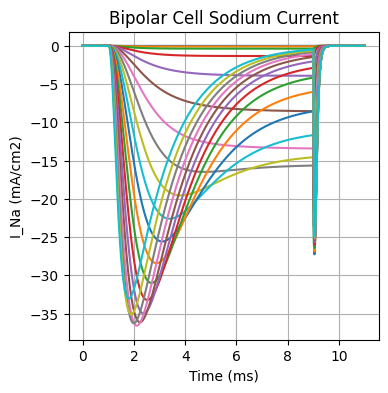

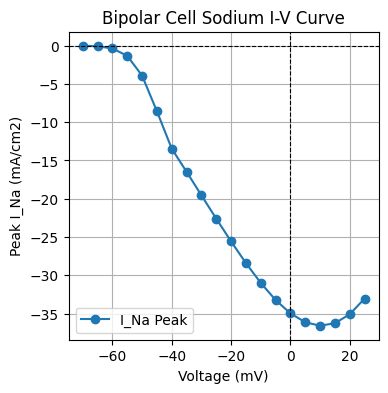

In [3]:
# Use np.min for Na+ inward current
soma = h.Section(name="soma")
soma.L = soma.diam = 20 
soma.nseg = 1
soma.insert("Bip_Na")
ena = 57.016 

for seg in soma:
    seg.ena = ena

Vs = np.arange(-70.0, 30.0, 5.0) 
plt.figure(figsize=(4,4))
for Vtest in Vs:
    tna, ina_trace = I_t_curve(soma, ion='na', Vtest=Vtest, Vhold=-80.0, thold=1.0, tstep=8.0, ljp=0)
    plt.plot(np.array(tna), ina_trace, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_Na (mA/cm2)')
plt.title('Bipolar Cell Sodium Current')
#plt.legend(fontsize='small', loc='lower right')
#plt.ylim(-10, 1)
plt.grid()
plt.show()


Vna, Ina_peak = I_V_curve(soma, ion='na', Vtests=Vs, Vhold=-80.0, thold=10.0, tstep=10.0, method=min, ljp=0)
plt.figure(figsize=(4,4))
plt.plot(Vna, Ina_peak, marker='o', label='I_Na Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I_Na (mA/cm2)')
plt.title('Bipolar Cell Sodium I-V Curve')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

# Kv

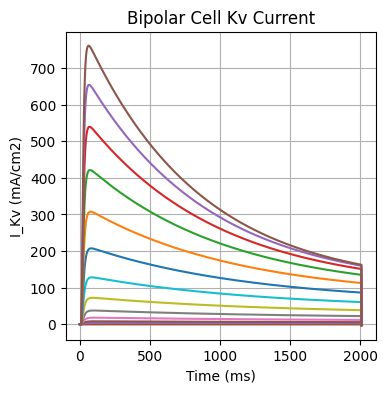

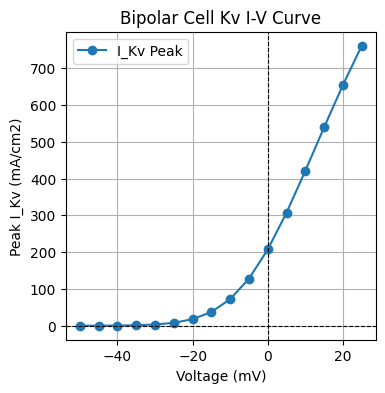

In [4]:
# Use np.max for outward K+ current.
soma = h.Section(name="soma")
soma.L = soma.diam = 20  # geometry not critical for current density
soma.nseg = 1

soma.insert("Bip_Kv")
ek = -58 # mV
for seg in soma:
    seg.ek = ek

Vs = np.arange(-50.0, 30.0, 5.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    tkv, ikv_trace = I_t_curve(soma, ion='k', Vtest=Vtest, Vhold=-60.0, thold=10.0, tstep=2000.0, ljp=0)
    plt.plot(np.array(tkv), ikv_trace, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_Kv (mA/cm2)')
plt.title('Bipolar Cell Kv Current')
plt.grid()
plt.show()

Vkv, Ikv_peak = I_V_curve(soma, ion='k', Vtests=Vs, Vhold=-60.0, thold=10.0, tstep=2000.0, method=max, ljp=0)
plt.figure(figsize=(4,4))
plt.plot(Vkv, Ikv_peak, marker='o', label='I_Kv Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I_Kv (mA/cm2)')
plt.title('Bipolar Cell Kv I-V Curve')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

# HCN1

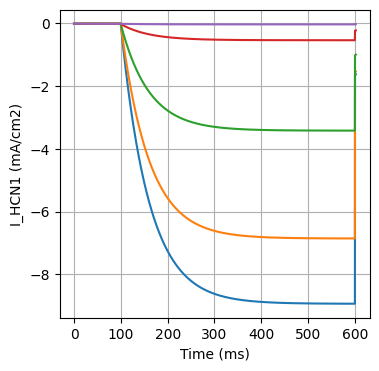

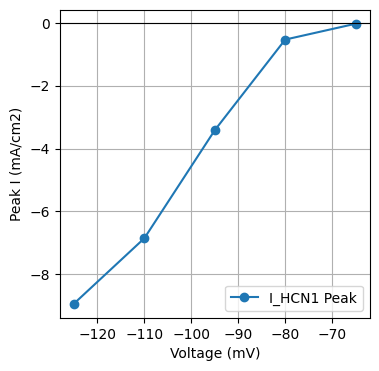

In [5]:
soma = h.Section(name="soma")
soma.L = soma.diam = 20  # geometry not critical for current density
soma.nseg = 1

soma.insert("Bip_HCN1")
eh = -45 # mV
for seg in soma:
    seg.eh = eh

Vs = np.arange(-125.0, -50.0, 15.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    thcn1, ihcn1 = I_t_curve(soma, ion='h', Vtest=Vtest, Vhold=-60.0, thold=100.0, tstep=500.0, ljp=LJP)
    plt.plot(np.array(thcn1), ihcn1, label=f'{Vtest} mV, HCN1')
plt.xlabel('Time (ms)')
plt.ylabel('I_HCN1 (mA/cm2)')
plt.grid()
plt.show()

Vhcn1, Ihcn1_peak = I_V_curve(soma, ion='h', Vtests=Vs, Vhold=-60.0, thold=100.0, tstep=500.0, method=min, ljp=LJP)
plt.figure(figsize=(4,4))
plt.plot(Vhcn1, Ihcn1_peak, marker='o', label='I_HCN1 Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I (mA/cm2)')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid()
plt.show()

# Kir

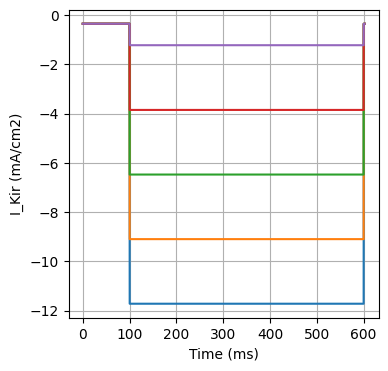

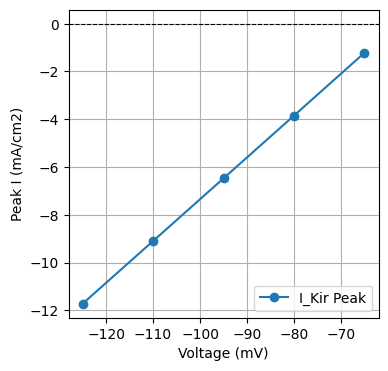

In [6]:
soma = h.Section(name="soma")
soma.L = soma.diam = 20  # geometry not critical for current density
soma.nseg = 1

soma.insert("Bip_Kir")
ek = -58 # mV
for seg in soma:
    seg.ek = ek

Vs = np.arange(-125.0, -50.0, 15.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    tkir, ikir_trace = I_t_curve(soma, ion='k', Vtest=Vtest, Vhold=-60.0, thold=100.0, tstep=500.0, ljp=LJP) 
    plt.plot(np.array(tkir), ikir_trace, label=f'{Vtest} mV, Kir only')
plt.xlabel('Time (ms)')
plt.ylabel('I_Kir (mA/cm2)')
plt.grid()
plt.show()

Vkir, Ikir_peak = I_V_curve(soma, ion='k', Vtests=Vs, Vhold=-60.0, thold=100.0, tstep=500.0, method=min, ljp=LJP)
plt.figure(figsize=(4,4))
plt.plot(Vkir, Ikir_peak, marker='o', label='I_Kir Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I (mA/cm2)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
#plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [7]:
# soma = h.Section(name="soma")
# soma.L = soma.diam = 20  # geometry not critical for current density
# soma.nseg = 1

# soma.insert("Bip_Kir")
# soma.insert("Bip_HCN1")
# eh = -45 # mV
# ek = -58 # mV
# for seg in soma:
#     seg.eh = eh
#     seg.ek = ek
#     seg.vshift_Bip_Kir = -53.08
#     seg.vshift_Bip_HCN1 = -53.08

# Vs = np.arange(-125.0, -50.0, 15.0)
# plt.figure(figsize=(4,4))
# for Vtest in Vs:
#     tkir, ikir_trace = I_t_curve(soma, ion='k', Vtest=Vtest, Vhold=-60.0, thold=100.0, tstep=500.0, ljp=LJP) 
#     thcn1, ihcn1 = I_t_curve(soma, ion='h', Vtest=Vtest, Vhold=-60.0, thold=100.0, tstep=500.0, ljp=LJP)
#     #plt.plot(np.array(tkir), ikir_trace + ihcn1, label=f'{Vtest} mV')
#     plt.plot(np.array(tkir), ikir_trace, label=f'{Vtest} mV, Kir only')
#     plt.plot(np.array(thcn1), ihcn1, label=f'{Vtest} mV, HCN1', linestyle='--')
# plt.xlabel('Time (ms)')
# plt.ylabel('I_Kir + I_HCN1 (mA/cm2)')
# plt.grid()
# plt.show()

# Vkir, Ikir_peak = I_V_curve(soma, ion='k', Vtests=Vs, Vhold=-60.0, thold=100.0, tstep=500.0, method=min, ljp=LJP)
# Vhcn1, Ihcn1_peak = I_V_curve(soma, ion='h', Vtests=Vs, Vhold=-60.0, thold=100.0, tstep=500.0, method=min, ljp=LJP)
# plt.figure(figsize=(10,4))
# plt.plot(Vkir, Ikir_peak, marker='o', label='I_Kir Peak')
# plt.plot(Vhcn1, (np.array(Ihcn1_peak) + np.array(Ikir_peak)), marker='o', label='I_HCN1 + I_Kir Peak')
# plt.xlabel('Voltage (mV)')
# plt.ylabel('Peak I (mA/cm2)')
# plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
# #plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
# plt.legend()
# plt.grid()
# plt.show()

# HCN 2

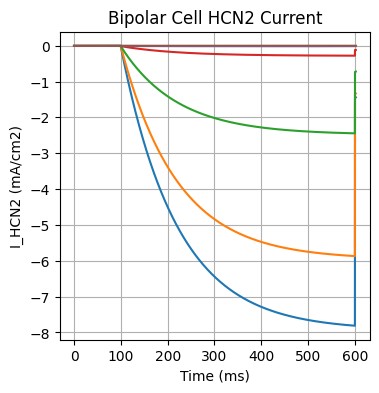

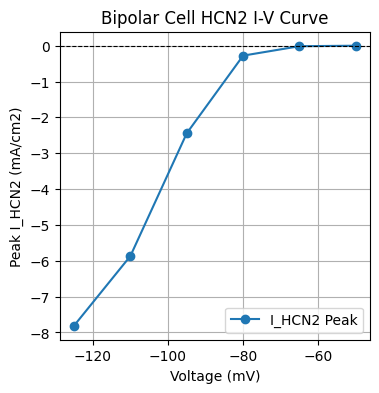

In [8]:
soma = h.Section(name="soma")
soma.L = soma.diam = 20  # geometry not critical for current density
soma.nseg = 1

soma.insert("Bip_HCN2")
eh = -45 # mV
for seg in soma:
    seg.eh = eh

Vs = np.arange(-125.0, -40.0, 15.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    thcn2, ihcn2_trace = I_t_curve(soma, ion='h', Vtest=Vtest, Vhold=-60.0, thold=100.0, tstep=500.0, ljp=0)
    plt.plot(np.array(thcn2), ihcn2_trace, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_HCN2 (mA/cm2)')
plt.title('Bipolar Cell HCN2 Current')
plt.grid()
plt.show()

Vhcn2, Ihcn2_peak = I_V_curve(soma, ion='h', Vtests=Vs, Vhold=-60.0, thold=100.0, tstep=500.0, method=min, ljp=0)
plt.figure(figsize=(4,4))
plt.plot(Vhcn2, Ihcn2_peak, marker='o', label='I_HCN2 Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I_HCN2 (mA/cm2)')
plt.title('Bipolar Cell HCN2 I-V Curve')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
#plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

# HCN 4

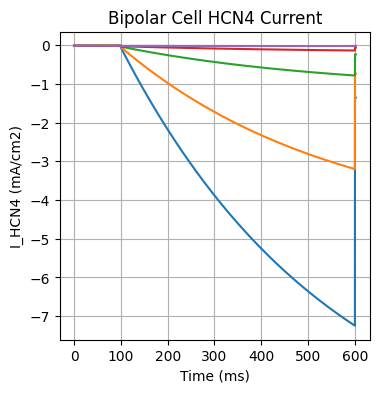

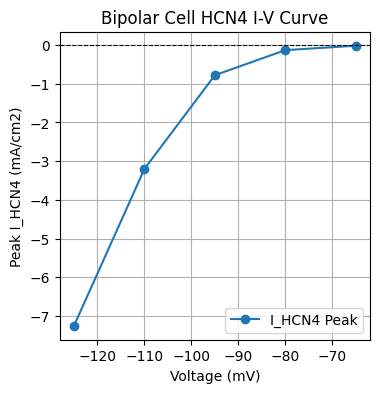

In [9]:
soma = h.Section(name="soma")
soma.L = soma.diam = 20  # geometry not critical for current density
soma.nseg = 1

soma.insert("Bip_HCN4")
eh = -45 # mV
for seg in soma:
    seg.eh = eh

Vs = np.arange(-125.0, -50.0, 15.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    thcn4, ihcn4_trace = I_t_curve(soma, ion='h', Vtest=Vtest, Vhold=-60.0, thold=100.0, tstep=500.0, ljp=0)
    plt.plot(np.array(thcn4), ihcn4_trace, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_HCN4 (mA/cm2)')
plt.title('Bipolar Cell HCN4 Current')
plt.grid()
plt.show()

Vhcn4, Ihcn4_peak = I_V_curve(soma, ion='h', Vtests=Vs, Vhold=-60.0, thold=100.0, tstep=500.0, method=min, ljp=0)
plt.figure(figsize=(4,4))
plt.plot(Vhcn4, Ihcn4_peak, marker='o', label='I_HCN4 Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I_HCN4 (mA/cm2)')
plt.title('Bipolar Cell HCN4 I-V Curve')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
#plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

# CaT

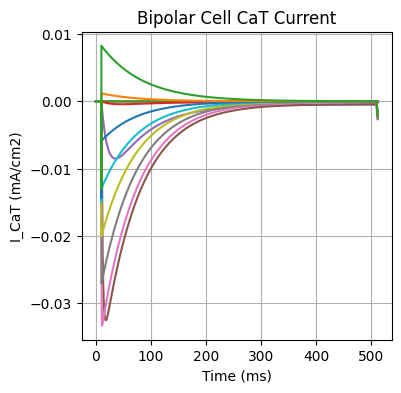

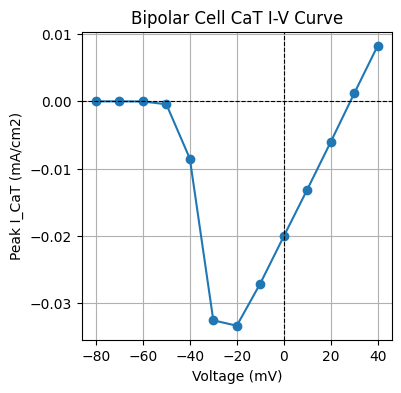

In [10]:
soma = h.Section(name="soma")
soma.L = soma.diam = 20  # geometry not critical for current density
soma.nseg = 1
soma.insert("Bip_CaT")

Vs = np.arange(-80.0, 50.0, 10.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    tcat, icat_trace = I_t_curve(soma, ion='ca', Vtest=Vtest, Vhold=-80.0, thold=10.0, tstep=500.0, ljp=0)
    plt.plot(np.array(tcat), icat_trace, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_CaT (mA/cm2)')
plt.title('Bipolar Cell CaT Current')
#plt.legend(fontsize='small', loc='upper right')
plt.grid()
plt.show()


Vcat, Icat_peak = I_V_curve(soma, ion='ca', Vtests=Vs, Vhold=-80.0, thold=10.0, tstep=500.0, method=min, ljp=0)
plt.figure(figsize=(4,4))
plt.plot(Vcat, Icat_peak, marker='o', label='I_CaT Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I_CaT (mA/cm2)')
plt.title('Bipolar Cell CaT I-V Curve') 
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
#plt.legend()
plt.grid()
plt.show()

# CaL

[-3.67669288e-07 -3.67669288e-07 -3.67665760e-07 ... -3.32766724e-07
 -3.32766844e-07 -3.32766964e-07]
[-3.67669288e-07 -3.67669288e-07 -3.67665760e-07 ... -3.15723082e-07
 -3.15723261e-07 -3.15723439e-07]
[-3.67669288e-07 -3.67669288e-07 -3.67665760e-07 ... -2.99239205e-07
 -2.99239439e-07 -2.99239674e-07]
[-3.67669288e-07 -3.67669288e-07 -3.67665760e-07 ... -2.83464291e-07
 -2.83464580e-07 -2.83464869e-07]
[-3.67669288e-07 -3.67669288e-07 -3.67665760e-07 ... -2.68519783e-07
 -2.68520123e-07 -2.68520463e-07]
[-3.67669288e-07 -3.67669288e-07 -3.67665760e-07 ... -2.54497025e-07
 -2.54497413e-07 -2.54497801e-07]
[-3.67669288e-07 -3.67669288e-07 -3.67665760e-07 ... -2.41457009e-07
 -2.41457442e-07 -2.41457875e-07]
[-3.67669288e-07 -3.67669288e-07 -3.67665760e-07 ... -2.29431923e-07
 -2.29432396e-07 -2.29432870e-07]
[-3.67669288e-07 -3.67669288e-07 -3.67665760e-07 ... -2.18428048e-07
 -2.18428560e-07 -2.18429071e-07]


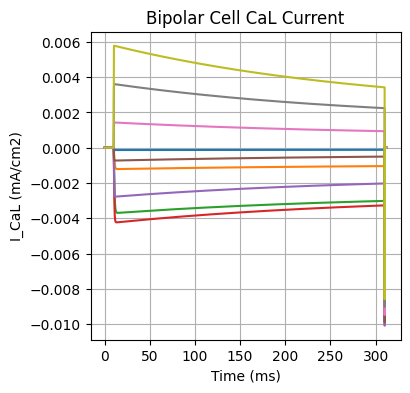

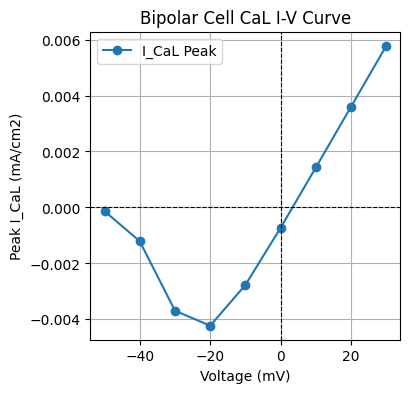

In [11]:
soma = h.Section(name="soma")
soma.L = soma.diam = 20  
soma.nseg = 1
soma.insert("Bip_CaL")


Vs = np.arange(-50.0, 40.0, 10.0)
plt.figure(figsize=(4,4))
for Vtest in Vs:
    tcal, ical_trace = I_t_curve(soma, ion='ca', Vtest=Vtest, Vhold=-70.0, thold=10.0, tstep=300.0, ljp=0)
    print(ical_trace)
    plt.plot(np.array(tcal), ical_trace, label=f'{Vtest} mV')
plt.xlabel('Time (ms)')
plt.ylabel('I_CaL (mA/cm2)')
plt.title('Bipolar Cell CaL Current')
#plt.ylim(-0.5, 0.5)
plt.grid()
plt.show()

Vcal, Ical_peak = I_V_curve(soma, ion='ca', Vtests=Vs, Vhold=-70.0, thold=10.0, tstep=300.0, method=min, ljp=0)
plt.figure(figsize=(4,4))
plt.plot(Vcal, Ical_peak, marker='o', label='I_CaL Peak')
plt.xlabel('Voltage (mV)')
plt.ylabel('Peak I_CaL (mA/cm2)')
plt.title('Bipolar Cell CaL I-V Curve')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

# KCa

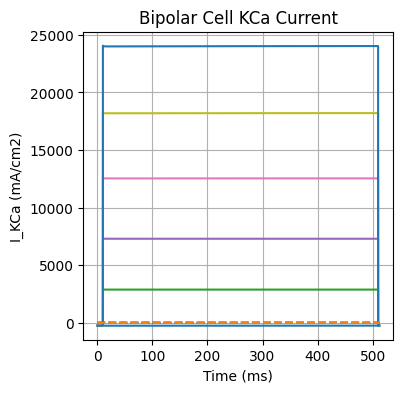

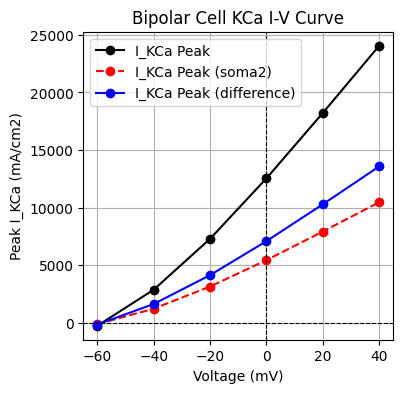

In [12]:
soma = h.Section(name="soma")
soma2 = h.Section(name="soma2")
soma.L = soma.diam = 20
soma2.L = soma2.diam = 20


soma.insert("Bip_KCa") 
soma2.insert("Bip_KCa") 
soma.insert("Bip_CaL")
soma2.insert("Bip_CaL")
soma.insert("Bip_caconc")
soma2.insert("Bip_caconc")


ek = - 58 # mV 
for seg in soma: 
    seg.ek = ek 
    seg.cainf_Bip_caconc = 0.8

for seg in soma2: 
    seg.ek = ek 
    seg.cainf_Bip_caconc = 0.1

Vs = np.arange(-60.0, 60.0, 20.0) 
plt.figure(figsize=(4,4)) 
for Vtest in Vs: 
    tkca, ikca_trace = I_t_curve(soma, ion='k', Vtest=Vtest, Vhold=-60.0, thold=10.0, tstep=500.0, ljp=0) 
    tkca2, ikca_trace2 = I_t_curve(soma2, ion='ca', Vtest=Vtest, Vhold=-60.0, thold=10.0, tstep=500.0, ljp=0) 
    plt.plot(np.array(tkca), ikca_trace, label=f'{Vtest} mV (soma)') 
    plt.plot(np.array(tkca2), ikca_trace2, label=f'{Vtest} mV (soma2)', linestyle='--') 
    #difference = ikca_trace - ikca_trace2
    #plt.plot(np.array(tkca), difference, label=f'{Vtest} mV (difference)') 
plt.xlabel('Time (ms)') 
plt.ylabel('I_KCa (mA/cm2)') 
plt.title('Bipolar Cell KCa Current') 
#plt.legend(fontsize="small") 
plt.grid() 
plt.show() 

Vcal, Ikca_peak = I_V_curve(soma, ion='k', Vtests=Vs, Vhold=-60.0, thold=10.0, tstep=500.0, method='mean', ljp=0) 
Vcal2, Ikca_peak2 = I_V_curve(soma2, ion='k', Vtests=Vs, Vhold=-60.0, thold=10.0, tstep=500.0, method='mean', ljp=0) 
difference = np.array(Ikca_peak) - np.array(Ikca_peak2)
plt.figure(figsize=(4,4)) 
plt.plot(Vcal, Ikca_peak, marker='o', label='I_KCa Peak', color= "black") 
plt.plot(Vcal2, Ikca_peak2, marker='o', label='I_KCa Peak (soma2)', linestyle='--', color = "red") 
plt.plot(Vcal, difference, marker='o', label='I_KCa Peak (difference)', color= "blue")
plt.xlabel('Voltage (mV)') 
plt.ylabel('Peak I_KCa (mA/cm2)') 
plt.title('Bipolar Cell KCa I-V Curve') 
plt.axhline(0, color='black', linewidth=0.8, linestyle='--') 
plt.axvline(0, color='black', linewidth=0.8, linestyle='--') 
plt.legend() 
plt.grid() 
plt.show()